In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import logging
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dask.distributed import Client
from replay_trajectory_classification import (
    SortedSpikesClassifier,
    ClusterlessClassifier,
)

from src.figure_utilities import (
    PAGE_HEIGHT,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY

set_figure_defaults()

In [3]:
epoch_key = "bon", 4, 2
ripple_number = 121

In [4]:
from src.load_data import load_data

data = load_data(epoch_key)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [5]:
from loren_frank_data_processing import (
    get_multiunit_dataframe,
    get_spikes_dataframe,
    make_neuron_dataframe,
)
from src.parameters import ANIMALS, _BRAIN_AREAS

neuron_info = make_neuron_dataframe(ANIMALS).xs(epoch_key, drop_level=False)
neuron_info = neuron_info.loc[
    (neuron_info.numspikes > 100)
    & neuron_info.area.isin(_BRAIN_AREAS)
    & (neuron_info.type == "principal")
]

In [6]:
spike_times = [
    get_spikes_dataframe(neuron_key, ANIMALS) for neuron_key in neuron_info.index
]

In [7]:
multiunit_times = [
    get_multiunit_dataframe(tetrode_key, ANIMALS)
    for tetrode_key in data["tetrode_info"].index
]

In [8]:
client = Client(processes=True, n_workers=16, threads_per_worker=4, memory_limit="50GB")
client

Client Scheduler: tcp://127.0.0.1:37105 Dashboard: http://127.0.0.1:35451/status,Cluster Workers: 16 Cores: 64 Memory: 800.00 GB


In [9]:
from src.parameters import (
    ANIMALS,
    FIGURE_DIR,
    PROBABILITY_THRESHOLD,
    PROCESSED_DATA_DIR,
    SAMPLING_FREQUENCY,
    TRANSITION_TO_CATEGORY,
    discrete_diag,
    knot_spacing,
    model,
    model_kwargs,
    movement_var,
    place_bin_size,
    replay_speed,
    spike_model_penalty,
)

position = data["position_info"].loc[:, ["x_position", "y_position"]]
is_training = data["position_info"].speed > 4

continuous_transition_types = [
    ["random_walk", "uniform", "identity"],  # noqa
    ["uniform", "uniform", "uniform"],  # noqa
    ["random_walk", "uniform", "identity"],
]  # noqa

classifier = ClusterlessClassifier(
    place_bin_size=place_bin_size,
    movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    continuous_transition_types=continuous_transition_types,
    model=model,
    model_kwargs=model_kwargs,
).fit(position, data["multiunit"], is_training=is_training)

In [10]:
ripple_start, ripple_end = (
    data["ripple_times"].loc[ripple_number].start_time,
    data["ripple_times"].loc[ripple_number].end_time,
)

In [11]:
time_slice = slice(*data["ripple_times"].loc[ripple_number, ["start_time", "end_time"]])
m = data["multiunit"].sel(time=time_slice)

results_2D = classifier.predict(m, m.time - m.time[0])

In [12]:
results_2D = results_2D.assign_coords(
    state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)
)

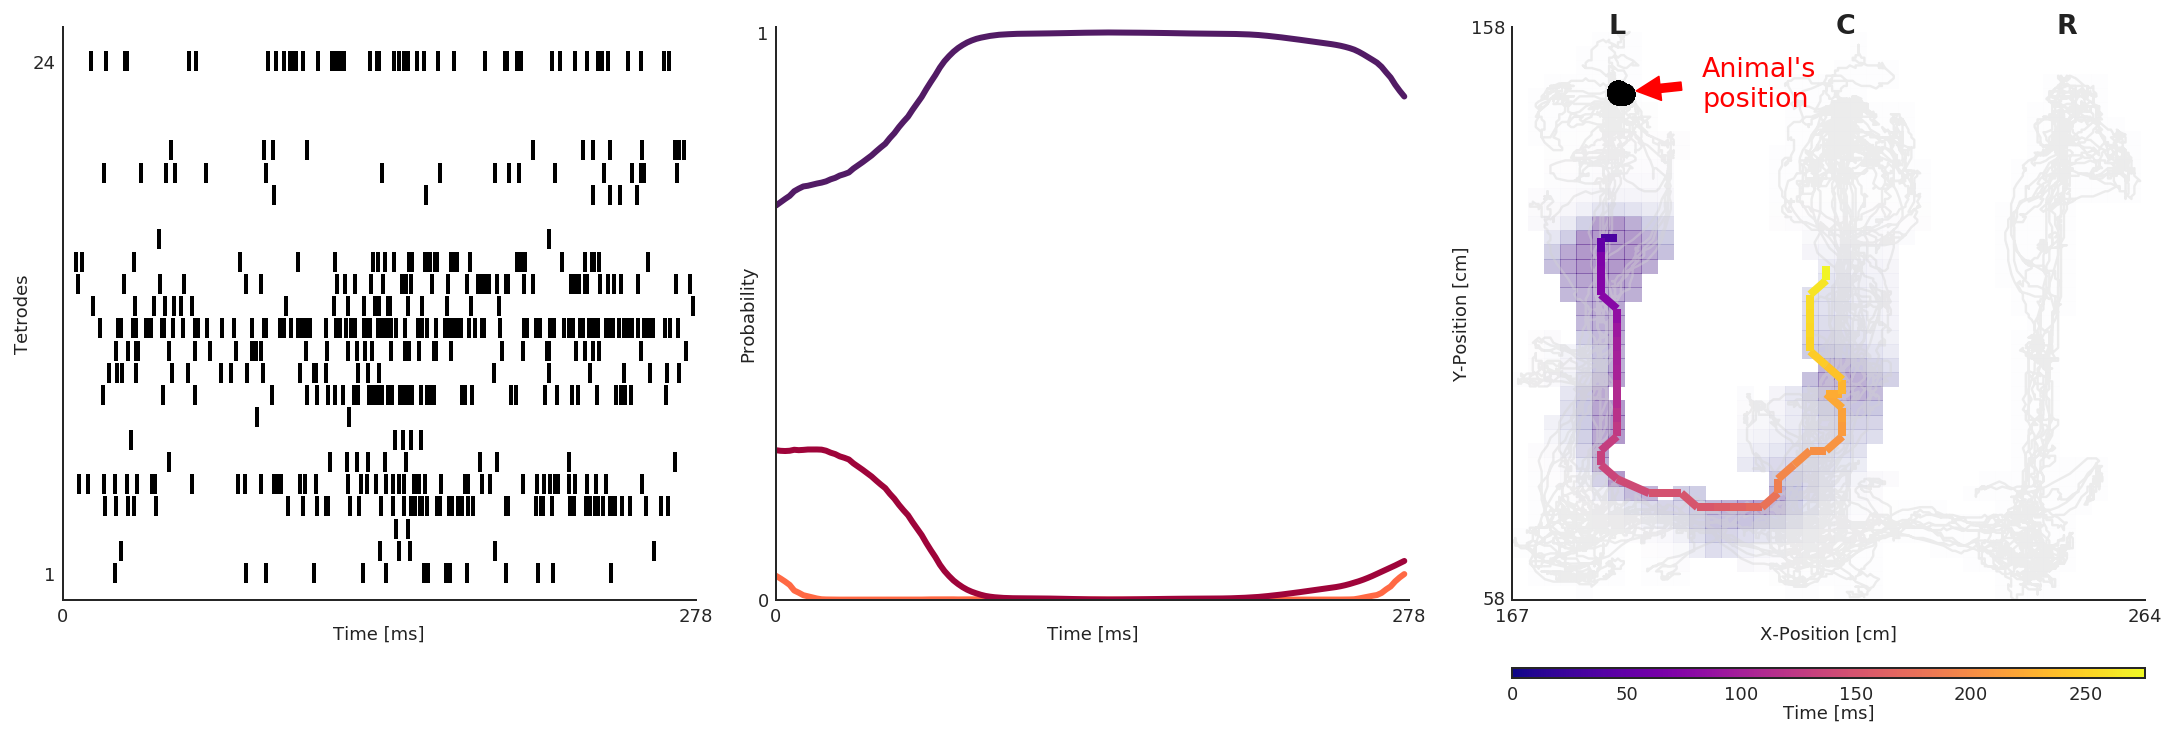

In [13]:
from src.analysis import maximum_a_posteriori_estimate
from src.visualization import plot_2D_position_with_color_time

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

MILLISECONDS_TO_SECONDS = 1000

n_tetrodes = len(multiunit_times)

for tetrode_ind, multiunit in enumerate(multiunit_times):
    times = (
        MILLISECONDS_TO_SECONDS
        * (multiunit.loc[ripple_start:ripple_end].index - ripple_start)
        / np.timedelta64(1, "s")
    )
    axes[0].scatter(
        times,
        np.ones_like(times) * (tetrode_ind + 1),
        marker="|",
        s=100,
        linewidth=2,
        color="black",
    )

axes[0].set_xlim(
    (0, MILLISECONDS_TO_SECONDS * (ripple_end - ripple_start) / np.timedelta64(1, "s"))
)
axes[0].set_xticks(
    (0, MILLISECONDS_TO_SECONDS * (ripple_end - ripple_start) / np.timedelta64(1, "s"))
)
axes[0].set_xlabel("Time [ms]")

axes[0].set_yticks((1, n_tetrodes))
axes[0].set_ylabel("Tetrodes")

probability = results_2D.acausal_posterior.sum(["x_position", "y_position"])

for state, prob in zip(results_2D.state.values, probability.values.T):
    axes[1].plot(
        MILLISECONDS_TO_SECONDS * probability.time / np.timedelta64(1, "s"),
        prob,
        linewidth=3,
        color=STATE_COLORS[state],
    )

axes[1].set_xlim(
    (0, MILLISECONDS_TO_SECONDS * (ripple_end - ripple_start) / np.timedelta64(1, "s"))
)
axes[1].set_xticks(
    (0, MILLISECONDS_TO_SECONDS * (ripple_end - ripple_start) / np.timedelta64(1, "s"))
)
axes[1].set_xlabel("Time [ms]")

axes[1].set_ylim((0, 1.01))
axes[1].set_yticks((0, 1))
axes[1].set_ylabel("Probability")


axes[2].plot(
    position.values[:, 0], position.values[:, 1], color="lightgrey", alpha=0.4, zorder=1
)
ripple_position = data["position_info"].loc[ripple_start:ripple_end]
axes[2].scatter(
    ripple_position["x_position"],
    ripple_position["y_position"],
    zorder=100,
    color="black",
    s=100,
)

map_estimate = maximum_a_posteriori_estimate(results_2D.acausal_posterior.sum("state"))
_, _, cbar = plot_2D_position_with_color_time(
    MILLISECONDS_TO_SECONDS * probability.time / np.timedelta64(1, "s"),
    map_estimate,
    ax=axes[2],
)
cbar.set_label("Time [ms]")

results_2D.acausal_posterior.sum(["state", "time"]).where(
    classifier.is_track_interior_
).plot(
    x="x_position",
    y="y_position",
    robust=True,
    cmap="Purples",
    alpha=0.4,
    ax=axes[2],
    add_colorbar=False,
    zorder=0,
    rasterized=True,
    edgecolors="none",
)
axes[2].text(183, 158, "L", ha="center", va="center", weight="bold", zorder=100)
axes[2].text(218, 158, "C", ha="center", va="center", weight="bold", zorder=100)
axes[2].text(252, 158, "R", ha="center", va="center", weight="bold", zorder=100)

axes[2].set_xlim((position.values[:, 0].min(), position.values[:, 0].max()))
axes[2].set_xticks(
    (np.ceil(position.values[:, 0].min()), np.ceil(position.values[:, 0].max()))
)
axes[2].set_xlabel("X-Position [cm]")

axes[2].set_ylim((position.values[:, 1].min(), position.values[:, 1].max()))
axes[2].set_yticks(
    (np.ceil(position.values[:, 1].min()), np.ceil(position.values[:, 1].max()))
)
axes[2].set_ylabel("Y-Position [cm]")


axes[2].annotate(
    "Animal's\nposition",
    xy=ripple_position.loc[:, ["x_position", "y_position"]].mean().tolist(),
    xycoords="data",
    xytext=(0.30, 0.90),
    textcoords="axes fraction",
    arrowprops=dict(shrink=0.20, color="red"),
    horizontalalignment="left",
    verticalalignment="center",
    color="red",
    zorder=200,
)

sns.despine()

In [14]:
from src.parameters import (
    ANIMALS,
    FIGURE_DIR,
    PROBABILITY_THRESHOLD,
    PROCESSED_DATA_DIR,
    SAMPLING_FREQUENCY,
    TRANSITION_TO_CATEGORY,
    continuous_transition_types,
    discrete_diag,
    knot_spacing,
    model,
    model_kwargs,
    movement_var,
    place_bin_size,
    replay_speed,
    spike_model_penalty,
)


is_training = data["position_info"].speed > 4
position = data["position_info"].loc[:, "linear_position"]
track_labels = data["position_info"].arm_name

classifier = ClusterlessClassifier(
    place_bin_size=place_bin_size,
    movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    continuous_transition_types=continuous_transition_types,
    model=model,
    model_kwargs=model_kwargs,
)
classifier.fit(
    position, data["multiunit"], is_training=is_training, track_labels=track_labels
)

ClusterlessClassifier(continuous_transition_types=[['w_track_1D_random_walk',
                                                    'uniform', 'identity'],
                                                   ['uniform', 'uniform',
                                                    'uniform'],
                                                   ['w_track_1D_random_walk',
                                                    'uniform', 'identity']],
                      discrete_transition_diag=0.99,
                      discrete_transition_type='strong_diagonal',
                      infer_track_interior=True,
                      initial_conditions_type='uniform_on_track',
                      model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                      model_kwargs={'bandwidth': array([24., 24., 24., 24.,  5.,  5.])},
                      movement_var=6.0,
                      occupancy_kwargs={'bandwidth': array([24., 24., 24., 24.,  5.,  5.])},
           

In [15]:
time_slice = slice(*data["ripple_times"].loc[ripple_number, ["start_time", "end_time"]])
m = data["multiunit"].sel(time=time_slice)

results_1D = classifier.predict(m, m.time - m.time[0])

In [16]:
results_1D = results_1D.assign_coords(
    state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)
)

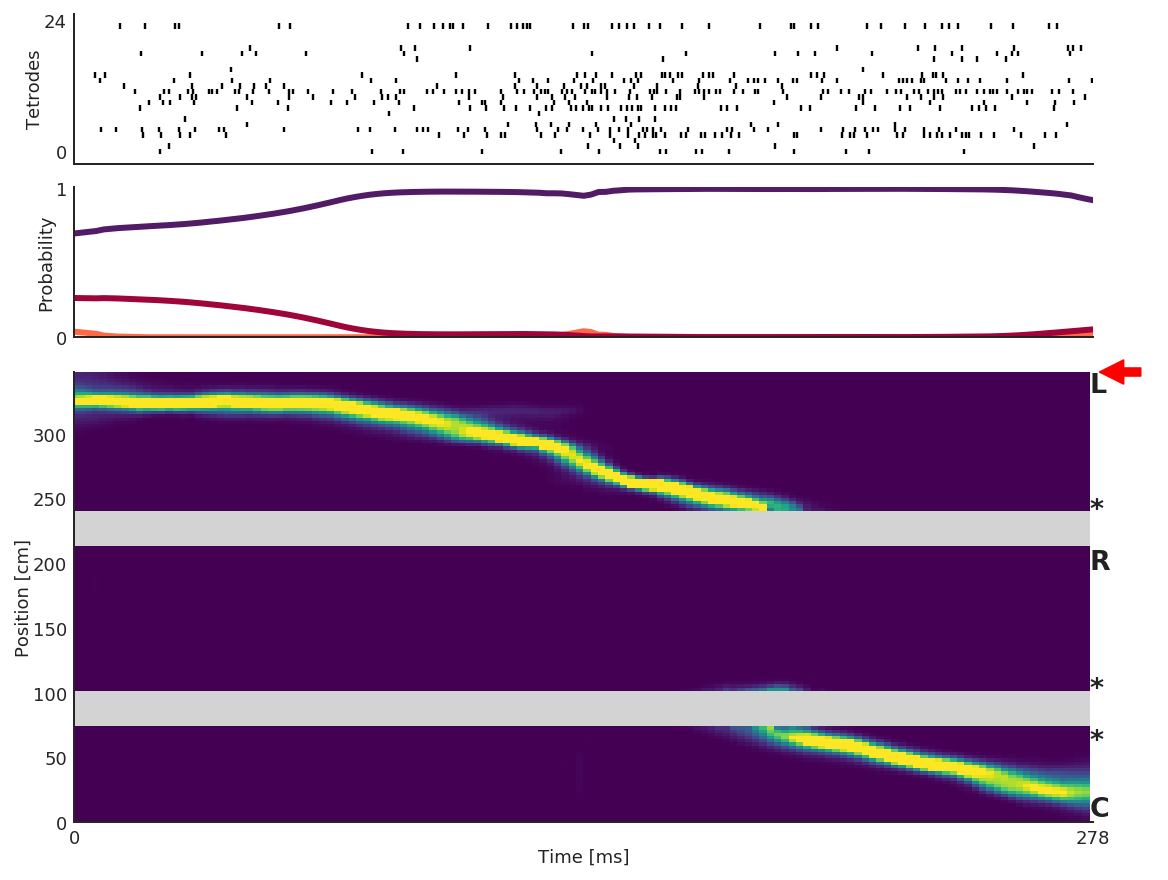

In [17]:
import copy

fig, axes = plt.subplots(
    3,
    1,
    sharex=True,
    constrained_layout=True,
    figsize=(8, 6),
    gridspec_kw={"height_ratios": [1, 1, 3]},
)

position = data["position_info"].loc[:, "linear_position"]

n_tetrodes = len(multiunit_times)

MILLISECONDS_TO_SECONDS = 1000

axes[0].eventplot(
    [
        MILLISECONDS_TO_SECONDS
        * (multiunit.loc[ripple_start:ripple_end].index - ripple_start)
        / np.timedelta64(1, "s")
        for multiunit in multiunit_times
    ],
    color="black",
)


axes[0].set_xlim(
    (0, MILLISECONDS_TO_SECONDS * (ripple_end - ripple_start) / np.timedelta64(1, "s"))
)
axes[0].set_xticks(
    (0, MILLISECONDS_TO_SECONDS * (ripple_end - ripple_start) / np.timedelta64(1, "s"))
)


axes[0].set_yticks((0, n_tetrodes))
axes[0].set_ylabel("Tetrodes")

probability = results_1D.acausal_posterior.sum(["position"])

for state, prob in zip(results_1D.state.values, probability.values.T):
    axes[1].plot(
        MILLISECONDS_TO_SECONDS * probability.time / np.timedelta64(1, "s"),
        prob,
        linewidth=3,
        color=STATE_COLORS[state],
    )

axes[1].set_ylim((0, 1.01))
axes[1].set_yticks((0, 1))
axes[1].set_ylabel("Probability")


cmap = copy.copy(plt.cm.get_cmap("viridis"))
cmap.set_bad(color="lightgrey", alpha=1.0)

(
    results_1D.assign_coords(
        time=lambda ds: MILLISECONDS_TO_SECONDS * ds.time / np.timedelta64(1, "s")
    )
    .acausal_posterior.sum("state")
    .where(classifier.is_track_interior_)
    .plot(
        x="time",
        y="position",
        robust=True,
        add_colorbar=False,
        zorder=0,
        rasterized=True,
        cmap=cmap,
    )
)

ripple_position = (
    data["position_info"].loc[ripple_start:ripple_end, "linear_position"].mean()
)
max_time = (MILLISECONDS_TO_SECONDS * probability.time / np.timedelta64(1, "s")).max()
axes[2].annotate(
    "",
    xy=(max_time, ripple_position),
    xycoords="data",
    xytext=(1.06, 1.0),
    textcoords="axes fraction",
    arrowprops=dict(shrink=0.2, color="red"),
    horizontalalignment="left",
    verticalalignment="center",
    color="red",
    zorder=200,
)
axes[2].set_xlim((0, max_time))
axes[2].set_xticks(
    (0, MILLISECONDS_TO_SECONDS * (ripple_end - ripple_start) / np.timedelta64(1, "s"))
)
axes[2].set_xlabel("Time [ms]")

arm_min_max = (
    data["position_info"].groupby("arm_name").linear_position.aggregate(["min", "max"])
)
axes[2].text(
    max_time + 1,
    arm_min_max.loc["Center Arm", "min"],
    "C",
    ha="left",
    va="bottom",
    weight="bold",
)
axes[2].text(
    max_time + 1,
    arm_min_max.loc["Center Arm", "max"],
    "*",
    ha="left",
    va="top",
    weight="bold",
)
axes[2].text(
    max_time + 1,
    arm_min_max.loc["Right Arm", "max"],
    "R",
    ha="left",
    va="top",
    weight="bold",
)
axes[2].text(
    max_time + 1,
    arm_min_max.loc["Right Arm", "min"],
    "*",
    ha="left",
    va="center",
    weight="bold",
)
axes[2].text(
    max_time + 1,
    arm_min_max.loc["Left Arm", "max"],
    "L",
    ha="left",
    va="top",
    weight="bold",
)
axes[2].text(
    max_time + 1,
    arm_min_max.loc["Left Arm", "min"],
    "*",
    ha="left",
    va="center",
    weight="bold",
)
axes[2].set_ylabel("Position [cm]")


sns.despine()

In [18]:
classifier = SortedSpikesClassifier(
    place_bin_size=place_bin_size,
    movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    spike_model_penalty=spike_model_penalty,
    knot_spacing=knot_spacing,
    continuous_transition_types=continuous_transition_types,
)
classifier.fit(
    position, data["spikes"], is_training=is_training, track_labels=track_labels
)

SortedSpikesClassifier(continuous_transition_types=[['w_track_1D_random_walk',
                                                     'uniform', 'identity'],
                                                    ['uniform', 'uniform',
                                                     'uniform'],
                                                    ['w_track_1D_random_walk',
                                                     'uniform', 'identity']],
                       discrete_transition_diag=0.99,
                       discrete_transition_type='strong_diagonal',
                       infer_track_interior=True,
                       initial_conditions_type='uniform_on_track',
                       knot_spacing=5, movement_var=6.0, place_bin_size=2.5,
                       position_range=None, replay_speed=1,
                       spike_model_penalty=0.5)

In [19]:
time_slice = slice(*data["ripple_times"].loc[ripple_number, ["start_time", "end_time"]])
s = data["spikes"].loc[time_slice]
results_1D_spikes = classifier.predict(s, time=s.index - s.index[0])

In [20]:
results_1D_spikes = results_1D_spikes.assign_coords(
    state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)
)

In [21]:
from src.analysis import get_place_field_max

place_field_max = get_place_field_max(classifier)
linear_position_order = place_field_max.argsort(axis=0).squeeze()

spike_times = [spike_times[i] for i in linear_position_order]

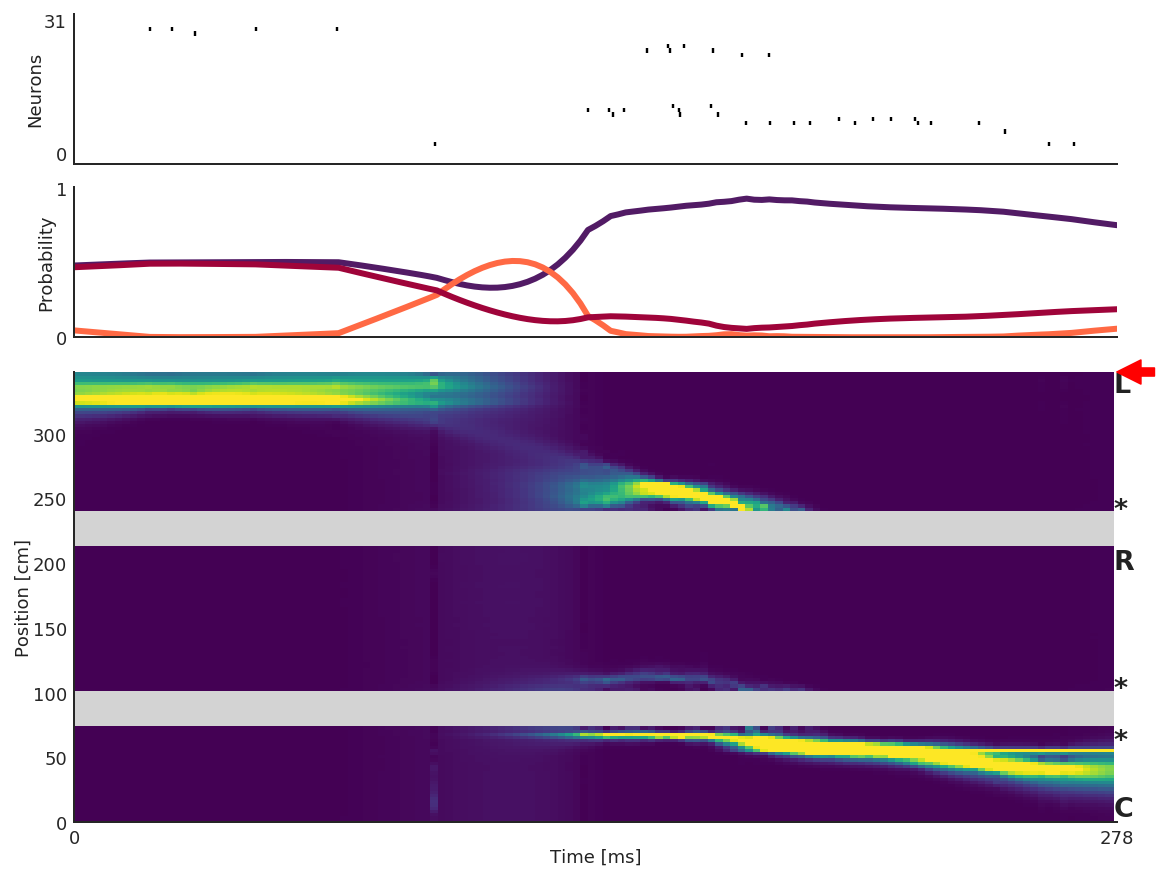

In [22]:
import copy

fig, axes = plt.subplots(
    3,
    1,
    sharex=True,
    constrained_layout=True,
    figsize=(8, 6),
    gridspec_kw={"height_ratios": [1, 1, 3]},
)

position = data["position_info"].loc[:, "linear_position"]

n_neurons = len(spike_times)

axes[0].eventplot(
    [
        MILLISECONDS_TO_SECONDS
        * (neuron.loc[ripple_start:ripple_end].index - ripple_start)
        / np.timedelta64(1, "s")
        for neuron in spike_times
    ],
    color="black",
)

axes[0].set_xlim(
    (0, MILLISECONDS_TO_SECONDS * (ripple_end - ripple_start) / np.timedelta64(1, "s"))
)
axes[0].set_xticks(
    (0, MILLISECONDS_TO_SECONDS * (ripple_end - ripple_start) / np.timedelta64(1, "s"))
)


axes[0].set_yticks((0, n_neurons))
axes[0].set_ylabel("Neurons")

probability = results_1D_spikes.acausal_posterior.sum(["position"])

for state, prob in zip(results_1D.state.values, probability.values.T):
    axes[1].plot(
        MILLISECONDS_TO_SECONDS * probability.time / np.timedelta64(1, "s"),
        prob,
        linewidth=3,
        color=STATE_COLORS[state],
    )

axes[1].set_ylim((0, 1.01))
axes[1].set_yticks((0, 1))
axes[1].set_ylabel("Probability")

cmap = copy.copy(plt.cm.get_cmap("viridis"))
cmap.set_bad(color="lightgrey", alpha=1.0)

(
    results_1D_spikes.assign_coords(
        time=lambda ds: MILLISECONDS_TO_SECONDS * ds.time / np.timedelta64(1, "s")
    )
    .acausal_posterior.sum("state")
    .where(classifier.is_track_interior_)
    .plot(
        x="time",
        y="position",
        robust=True,
        add_colorbar=False,
        zorder=0,
        rasterized=True,
        cmap=cmap,
    )
)

ripple_position = (
    data["position_info"].loc[ripple_start:ripple_end, "linear_position"].mean()
)
max_time = (MILLISECONDS_TO_SECONDS * probability.time / np.timedelta64(1, "s")).max()
ripple_duration = (
    MILLISECONDS_TO_SECONDS
    * (time_slice.stop - time_slice.start)
    / np.timedelta64(1, "s")
)
axes[2].annotate(
    "",
    xy=(max_time + 2, ripple_position),
    xycoords="data",
    xytext=(max_time + 12, ripple_position),
    textcoords="data",
    arrowprops=dict(shrink=0.00, color="red"),
    horizontalalignment="left",
    verticalalignment="center",
    color="red",
    zorder=200,
)
axes[2].set_xlim((0, max_time))
axes[2].set_xticks(
    (0, MILLISECONDS_TO_SECONDS * (ripple_end - ripple_start) / np.timedelta64(1, "s"))
)
axes[2].set_xlabel("Time [ms]")

arm_min_max = (
    data["position_info"].groupby("arm_name").linear_position.aggregate(["min", "max"])
)
axes[2].text(
    max_time + 1,
    arm_min_max.loc["Center Arm", "min"],
    "C",
    ha="left",
    va="bottom",
    weight="bold",
)
axes[2].text(
    max_time + 1,
    arm_min_max.loc["Center Arm", "max"],
    "*",
    ha="left",
    va="top",
    weight="bold",
)
axes[2].text(
    max_time + 1,
    arm_min_max.loc["Right Arm", "max"],
    "R",
    ha="left",
    va="top",
    weight="bold",
)
axes[2].text(
    max_time + 1,
    arm_min_max.loc["Right Arm", "min"],
    "*",
    ha="left",
    va="center",
    weight="bold",
)
axes[2].text(
    max_time + 1,
    arm_min_max.loc["Left Arm", "max"],
    "L",
    ha="left",
    va="top",
    weight="bold",
)
axes[2].text(
    max_time + 1,
    arm_min_max.loc["Left Arm", "min"],
    "*",
    ha="left",
    va="center",
    weight="bold",
)
axes[2].set_ylabel("Position [cm]")


sns.despine()